In [1]:
pip install pyTelegramBotApi

     |████████████████████████████████| 92kB 3.8MB/s 
  Created wheel for pyTelegramBotApi: filename=pyTelegramBotAPI-3.7.9-cp37-none-any.whl size=67913 sha256=ec7aa9d7c13fd6203b1ddfcce740e07ac0f262443b0fed57460b82ac1fdd5a84
  Stored in directory: /root/.cache/pip/wheels/68/bb/cb/1af3be2487e0e183f3848e9d555acdf4df4628637fab5b9939
Successfully built pyTelegramBotApi


In [2]:
import requests
from bs4 import BeautifulSoup


def currencies(v1, v2):
    URL = "http://www.cbr.ru/scripts/XML_daily.asp"

    resp = requests.get(URL)
    soup = BeautifulSoup(resp.content, "xml")

    v1 = currency_dict[v1]
    v2 = currency_dict[v2]

    if v1 == 'Российский рубль':
        value1, nominal1 = 1.0, 1.0
    else:
        valute1 = soup.find('Name', text=v1).find_previous('Valute')
        nominal1 = int(valute1.Nominal.string)
        value1 = float(valute1.Value.string.replace(',', '.'))
    if v2 == 'Российский рубль':
        value2, nominal2 = 1.0, 1.0
    else:
        valute2 = soup.find('Name', text=v2).find_previous('Valute')
        nominal2 = int(valute2.Nominal.string)
        value2 = float(valute2.Value.string.replace(',', '.'))

    return (value1 / nominal1) / (value2 / nominal2)


currency_dict = {'Австралийский доллар': 'Австралийский доллар', 'Азербайджанский манат': 'Азербайджанский манат', 'Британский фунт стерлингов': 'Фунт стерлингов Соединенного королевства',
                 'Армянский драм': 'Армянских драмов', 'Белорусский рубль': 'Белорусский рубль', 'Болгарский лев': 'Болгарский лев', 'Бразильский реал': 'Бразильский реал',
                 'Венгерский форинт': 'Венгерских форинтов', 'Гонконгский доллар': 'Гонконгских долларов', 'Датская крона': 'Датская крона', 'Доллар США': 'Доллар США', 'Евро': 'Евро',
                 'Индийская рупия': 'Индийских рупий', 'Казахстанский тенге': 'Казахстанских тенге', 'Канадский доллар': 'Канадский доллар', 'Киргизский сом': 'Киргизских сомов',
                 'Китайский юань': 'Китайский юань', 'Молдавский лей': 'Молдавских леев', 'Норвежская крона': 'Норвежских крон', 'Польский злотый': 'Польский злотый', 'Румынский лей': 'Румынский лей',
                 'Сингапурский доллар': 'Сингапурский доллар', 'Таджикский сомони': 'Таджикских сомони', 'Турецкая лира': 'Турецких лир', 'Туркменский манат': 'Новый туркменский манат',
                 'Узбекский сум': 'Узбекских сумов', 'Украинская гривна': 'Украинских гривен', 'Чешская крона': 'Чешских крон', 'Шведская крона': 'Шведских крон', 'Швейцарский франк': 'Швейцарский франк',
                 'Южноафриканский рэнд': 'Южноафриканских рэндов', 'Южнокорейская вона': 'Вон Республики Корея', 'Японская иена': 'Японских иен', 'Российский рубль': 'Российский рубль'}

In [26]:
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")


# Генератор данных для LSTM
class DataGeneratorSeq(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length // self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        batch_data = np.zeros((self._batch_size), dtype=np.float32)
        batch_labels = np.zeros((self._batch_size), dtype=np.float32)
        for b in range(self._batch_size):
            if self._cursor[b] + 1 >= self._prices_length:
                self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(1, 5)]
            self._cursor[b] = (self._cursor[b] + 1) % self._prices_length
        return batch_data, batch_labels

    def unroll_batches(self):
        unroll_data, unroll_labels = [], []
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels


def buy_or_sell(ticker, epochs, n_predict_once):
    # Получение данных
    api_key = 'GUL2XL60LNWB05XE'
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s" %\
                 (ticker, api_key)
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date', 'Low', 'High', 'Close', 'Open'])
        for k, v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(), float(v['3. low']), float(v['2. high']), float(v['4. close']), float(v['1. open'])]
            df.loc[-1, :] = data_row
            df.index = df.index + 1
    df.sort_values('Date', inplace=True)

    # Разбиение исходных данных на обучающую и тестовую выборки
    high_prices = df.loc[:, 'High'].to_numpy()
    low_prices = df.loc[:, 'Low'].to_numpy()
    mid_prices = (high_prices + low_prices) / 2.0
    len_data = len(mid_prices)
    len_train = len_data * 2 // 3
    train_data = mid_prices[:len_train]
    test_data = mid_prices[len_train:]
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)

    # Нормализация
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    train_data = scaler.transform(train_data).reshape(-1)
    test_data = scaler.transform(test_data).reshape(-1)

    # Сглаживание обучающей выборки
    EMA = 0.0
    gamma = 0.1
    for ti in range(len_train):
        EMA = gamma * train_data[ti] + (1 - gamma) * EMA
        train_data[ti] = EMA
    all_mid_data = np.concatenate([train_data, test_data], axis=0)

    # Определение гиперпараметров
    D = 1
    num_unrollings = 50
    batch_size = 250
    num_nodes = [200, 200, 150]
    n_layers = len(num_nodes)
    dropout = 0.2
    tf.reset_default_graph()

    # Определение входов и выходов
    train_inputs, train_outputs = [], []
    for ui in range(num_unrollings):
        train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size, D], name='train_inputs_%d' % ui))
        train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size, 1], name='train_outputs_%d' % ui))

    # Определение параметров для LSTM и регрессии
    lstm_cells = [
        tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                                state_is_tuple=True,
                                initializer=tf.contrib.layers.xavier_initializer())
        for li in range(n_layers)]
    drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
        lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
    ) for lstm in lstm_cells]
    drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
    multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
    w = tf.get_variable('w', shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b', initializer=tf.random_uniform([1], -0.1, 0.1))

    # Расчет выводов LSTM
    c, h = [], []
    initial_state = []
    for li in range(n_layers):
        c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
        h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
        initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))
    all_inputs = tf.concat([tf.expand_dims(t, 0) for t in train_inputs], axis=0)
    all_lstm_outputs, state = tf.nn.dynamic_rnn(
        drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
        time_major=True, dtype=tf.float32)
    all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])
    all_outputs = tf.nn.xw_plus_b(all_lstm_outputs, w, b)
    split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

    # Расчет потерь
    loss = 0.0
    with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)] +
                                 [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
        for ui in range(num_unrollings):
            loss += tf.reduce_mean(0.5 * (split_outputs[ui] - train_outputs[ui]) ** 2)
    global_step = tf.Variable(0, trainable=False)
    inc_gstep = tf.assign(global_step, global_step + 1)
    tf_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
    tf_min_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
    learning_rate = tf.maximum(
        tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
        tf_min_learning_rate)

    # Оптимизатор
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    optimizer = optimizer.apply_gradients(zip(gradients, v))

    # Расчет прогнозирования
    sample_inputs = tf.placeholder(tf.float32, shape=[1, D])
    sample_c, sample_h, initial_sample_state = [], [], []
    for li in range(n_layers):
        sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
        sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
        initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li], sample_h[li]))
    reset_sample_states = tf.group(*[tf.assign(sample_c[li], tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                                   *[tf.assign(sample_h[li], tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])
    sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs, 0),
                                                     initial_state=tuple(initial_sample_state),
                                                     time_major=True,
                                                     dtype=tf.float32)
    with tf.control_dependencies([tf.assign(sample_c[li], sample_state[li][0]) for li in range(n_layers)] +
                                 [tf.assign(sample_h[li], sample_state[li][1]) for li in range(n_layers)]):
        sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs, [1, -1]), w, b)

    # Запуск LSTM
    # epochs и n_predict_once получаем как параметр
    valid_summary = 1
    train_mse_ot = []
    test_mse_ot = []
    predictions_over_time = []

    session = tf.InteractiveSession()
    tf.global_variables_initializer().run()

    loss_nondecrease_count = 0
    loss_nondecrease_threshold = 2
    average_loss = 0
    data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)
    x_axis_seq = []
    test_points_seq = np.arange(len_data - (len_data - len_train) // n_predict_once * n_predict_once, len_data,
                                n_predict_once).tolist()

    for ep in range(epochs):
        # ========================= Обучение =====================================
        for step in range(len_train // batch_size):
            u_data, u_labels = data_gen.unroll_batches()
            feed_dict = {}
            for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
                feed_dict[train_inputs[ui]] = dat.reshape(-1, 1)
                feed_dict[train_outputs[ui]] = lbl.reshape(-1, 1)
            feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate: 0.000001})
            _, l_0 = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l_0

        # ============================ Валидация ==============================
        # Средние потери
        average_loss = average_loss / (valid_summary * (len_train // batch_size))
        print('Average loss at step %d: %f' % (ep + 1, average_loss))

        train_mse_ot.append(average_loss)
        average_loss = 0
        predictions_seq = []
        mse_test_loss_seq = []

        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []
            if (ep + 1) - valid_summary == 0:
                x_axis = []
            for tr_i in range(w_i - num_unrollings + 1, w_i - 1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)
                _ = session.run(sample_prediction, feed_dict=feed_dict)
            feed_dict = {}
            current_price = all_mid_data[w_i - 1]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)

            # Каждый раз в качестве текущего ввода используется предыдущий прогноз
            for pred_i in range(n_predict_once):
                pred = session.run(sample_prediction, feed_dict=feed_dict)
                our_predictions.append(np.asscalar(pred))
                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1, 1)
                if (ep + 1) - valid_summary == 0:
                    x_axis.append(w_i + pred_i)
                mse_test_loss += 0.5 * (pred - all_mid_data[w_i + pred_i]) ** 2

            session.run(reset_sample_states)
            predictions_seq.append(np.array(our_predictions))
            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)
            if (ep + 1) - valid_summary == 0:
                x_axis_seq.append(x_axis)            

        # Контрольное предсказание
        feed_dict = {}
        our_predictions = []
        w_i = len_data
        for tr_i in range(w_i - num_unrollings + 1, w_i - 1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)
          _ = session.run(sample_prediction, feed_dict=feed_dict)
        feed_dict = {}
        current_price = all_mid_data[w_i - 1]
        feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)
        for pred_i in range(n_predict_once):
          pred = session.run(sample_prediction, feed_dict=feed_dict)
          our_predictions.append(np.asscalar(pred))
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1, 1)
        predictions_seq.append(np.array(our_predictions))
        session.run(reset_sample_states)

        # Эффективность предсказании
        current_test_mse = np.mean(mse_test_loss_seq)
        if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0
        if loss_nondecrease_count > loss_nondecrease_threshold:
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f' % np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)

    x_axis_seq.append(np.arange(len_data, len_data+n_predict_once).tolist())

    # Купить или продать?
    min_test_loss = min(test_mse_ot)
    for i in range(epochs - 1, -1, -1):
        if min_test_loss == test_mse_ot[i]:
            break
    best_prediction_epoch = i
    old_price = all_mid_data[len_data-1]
    buy_or_sell_ans = 0.0
    for i in range(n_predict_once):
        buy_or_sell_ans += (predictions_over_time[best_prediction_epoch][-1][i] - old_price) * (1-i/n_predict_once)
        old_price = predictions_over_time[best_prediction_epoch][-1][i]

    vizualize(predictions_over_time[best_prediction_epoch], len_train, len_data, all_mid_data, x_axis_seq, n_predict_once)
    return len_data, int(buy_or_sell_ans > 0)


def vizualize(best_predictions, len_train, len_df, all_mid_data, x_axis_seq, n_predict_once):
    plt.figure(figsize = (18,18))
    plt.subplot(2,1,2)

    plt.plot(range(len_df),all_mid_data,color='b')
    if n_predict_once == 1:
        plt.plot(x_axis_seq,best_predictions,color='r')
    else:
        for xval,yval in zip(x_axis_seq,best_predictions):
            plt.plot(xval,yval,color='r')
        
    plt.title('Лучшее предсказание',fontsize=18)
    plt.xlabel('Дата',fontsize=18)
    plt.ylabel('Нормализованная средняя цена',fontsize=18)
    plt.xlim(len_train, len_df+n_predict_once)
    plt.savefig('plt.png')
    plt.show()


trading_dict = {'Аэрофлот': 'AFL', 'Газпром нефть': 'GZPFY', 'Мосэнергосбыт': 'AOMOY',
              'Газпром': 'OGZPY', 'Лукойл': 'LUKOY', 'Норникель': 'NILSY', 'Полюс': 'OPYGY',
              'Татнефть': 'OAOFY', 'Полиметалл': 'AUCOY', 'Приморское морское пароходство': 'PRIM',
              'Ростелеком': 'ROSYY', 'Русгидро': 'RSHYY', 'Сургутнефтегаз': 'SGTZY', 'HeadHunter': 'HHR',
              'МЕЧЕЛ': 'MTL', 'МТС': 'MBT', 'Ozon Holdings': 'OZON', 'Qiwi': 'QIWI', 'Яндекс': 'YNDX',
              'Тинькофф банк': 'TCS', 'Tesla': 'TSLA'}

In [40]:
import telebot as tb
from telebot import types

TOKEN = "1642580597:AAHI6xyB8O5HPQq2o_dw4LPfOX62Ta5llJk"
bot = tb.TeleBot(TOKEN)

prev_request = [-1, []]

markup_currency = types.ReplyKeyboardMarkup(one_time_keyboard=True, row_width=5)
for key in sorted(currency_dict):
    markup_currency.row(types.KeyboardButton(key))

markup_trading = types.ReplyKeyboardMarkup(one_time_keyboard=True, row_width=5)
for key in sorted(trading_dict):
    markup_trading.row(types.KeyboardButton(key))

markup_start = types.ReplyKeyboardMarkup(one_time_keyboard=True, row_width=5)
markup_start.row(types.KeyboardButton('Узнать курс валют'))
markup_start.row(types.KeyboardButton('Купить или продать акции?'))


markup_qur_ans = types.ReplyKeyboardMarkup(one_time_keyboard=True, row_width=5)
markup_qur_ans.row(types.KeyboardButton('Хочу обратный курс'))
markup_qur_ans.row(types.KeyboardButton('Узнать курс валют'))
markup_qur_ans.row(types.KeyboardButton('Купить или продать акции?'))


@bot.message_handler(commands=['start'])
def send_welcome(message):
    global prev_request
    prev_request = [-1, []]
    massage_s = "Привет, я твой помощник в сфере финансов.\n" + \
                "Я умею:\n" + \
                "  • выдать курс валют\n" + \
                "  • подсказать купить или продать акции\n\n" + \
                "Чем могу помочь?"
    bot.send_message(message.chat.id, massage_s, reply_markup=markup_start)


@bot.message_handler(content_types=['text'])
def start_message(message):
    global prev_request
    text = message.text
    if text == 'Узнать курс валют':
        prev_request = [1, []]
        bot.send_message(message.chat.id, "Выберайте первую валюту", reply_markup=markup_currency)
    elif text == 'Купить или продать акции?':
        prev_request = [2, []]
        bot.send_message(message.chat.id, "Выберайте компанию", reply_markup=markup_trading)
    elif prev_request[0] == 1:
        if len(prev_request[1]) == 0:
            if text in currency_dict:
                prev_request[1].append(text)
                bot.send_message(message.chat.id, "Выберайте вторую валюту", reply_markup=markup_currency)
            else:
                bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')
        elif len(prev_request[1]) == 1:
            if text in currency_dict:
                prev_request[1].append(text)
                bot.send_message(message.chat.id, currencies(prev_request[1][0], prev_request[1][1]))
                bot.send_message(message.chat.id, 'Ещё чем могу помочь?', reply_markup=markup_qur_ans)
            else:
                bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')
        elif text == 'Хочу обратный курс':
            bot.send_message(message.chat.id, currencies(prev_request[1][1], prev_request[1][0]))
            prev_request = [-1, []]
            bot.send_message(message.chat.id, 'Ещё чем могу помочь?', reply_markup=markup_start)
        else:
            bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')
    elif prev_request[0] == 2:
        if len(prev_request[1]) == 0:
            if text in trading_dict:
                prev_request[1].append(text)
                bot.send_message(message.chat.id, 'Вводите через пробел количество эпох и количесво предсказаний в один ход')
            else:
                bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')
        elif len(prev_request[1]) == 1:
            ep_pr = text.split()
            if len(ep_pr) == 2 and ep_pr[0].isdigit() and ep_pr[1].isdigit():
                bot.send_message(message.chat.id, 'Подождите, пожалуйста, я обучаюсь')
                epochs, n_predict_once = int(ep_pr[0]), int(ep_pr[1])
                len_of_data, ans = buy_or_sell(trading_dict[prev_request[1][0]], epochs, n_predict_once)
                ans = 'купить' if ans == 1 else 'продать'
                answer = 'Я нашел ' + str(len_of_data) + ' данных, рассмотрел их, и советую ' + ans + ' акции данной компании.\n' + \
                         'Отправляю Вам визуализацию сделанных предсказаний.'
                print(answer)
                bot.send_message(message.chat.id, answer)
                bot.send_photo(message.chat.id, photo=open('plt.png', 'rb'))
                prev_request = [-1, []]
                bot.send_message(message.chat.id, 'Ещё чем могу помочь?', reply_markup=markup_start)
            else:
                bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')
        else:
            bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')
    else:
        bot.send_message(message.chat.id, 'Неправильный ввод, попробуйте заново')

Average loss at step 1: 4.277422
	Test MSE: 0.73011


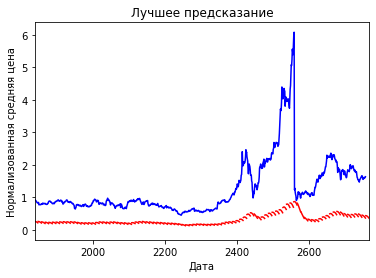

In [25]:
bot.polling(none_stop=True, interval=0)

In [6]:
def test1():
    for key in currency_dict:
        print(currencies(key, 'Российский рубль'))

def test2():
    for n_predict_once in [1, 2, 10, 20, 50, 100]:
      for epochs in [1, 3, 10, 30]:
          len_of_data, ans = buy_or_sell(trading_dict['Аэрофлот'], epochs, n_predict_once)
          print('\tepochs = ', epochs, ', n_predict_once =', n_predict_once, sep='')
          print('\t\tС учётом', len_of_data, 'данных, бот советует', 'купить' if ans == 1 else 'продать', 'акции данной компании')
          print('='*100)

# test1()
# test2()